In [3]:
import os
import sys
import json
from collections import Counter

import numpy as np
import matplotlib.pyplot as plt

PROJECT_DIR = os.path.dirname(os.path.dirname(os.getcwd()))
sys.path.append(PROJECT_DIR)

DATA_DIR = os.path.join(PROJECT_DIR, "data")
METADATA_DIR = os.path.join(DATA_DIR, "discogs_metadata")

def get_youtube_id(url):
    return url.split("/watch?v=")[1]

In [4]:
dump_date = "20240701"

use_discogs_vi = True # If false use discogs_vi_yt

In [5]:
MUSIC_DIR = 'directory_to_store_the_music'

figures_dir = os.path.join(DATA_DIR, "figures", f"discogs_{dump_date}")
os.makedirs(figures_dir, exist_ok=True)

dump_name = f"discogs_{dump_date}"

dump_dir = os.path.join(METADATA_DIR, dump_name)
print(os.path.abspath(dump_dir))

discogs_vi_json = os.path.join(dump_dir, f"Discogs-VI-{dump_date}.jsonl")
discogs_vi_yt_json = os.path.join(dump_dir, f"Discogs-VI-YT-{dump_date}.jsonl")

if use_discogs_vi:
    intersection_text = os.path.join(dump_dir, f'Discogs-VI-{dump_date}-DaTACOS-SHS100K2_TEST-lost_cliques.txt')
else:
    intersection_text = os.path.join(dump_dir, f'Discogs-VI-YT-{dump_date}-DaTACOS-SHS100K2_TEST-lost_cliques.txt')

discogs_vi_yt_light_path = os.path.join(dump_dir, f"Discogs-VI-YT-{dump_date}-light.json")
dataset_train_path = discogs_vi_yt_light_path + '.train'
dataset_test_path = discogs_vi_yt_light_path + '.test'
dataset_val_path = discogs_vi_yt_light_path + '.val'

/home/oaraz/discotube-dataset/data/discogs_metadata/discogs_20240701


## Discogs-VI-YT-Light

In [4]:
with open(discogs_vi_yt_light_path, 'r') as in_f:
    dataset = json.load(in_f)

# Count the number of versions per clique
n_total_cliques = len(dataset)
print(f" Number of total cliques: {n_total_cliques:>7,}")
n_versions_per_clique = Counter([len(clique) for clique in dataset.values()])
n_total_versions = sum([len(clique) for clique in dataset.values()])
print(f"Number of total versions: {n_total_versions:>7,}")

 Number of total cliques:  98,785
Number of total versions: 493,049


In [5]:
sorted(n_versions_per_clique.items(), key=lambda x:x[0])

[(2, 55791),
 (3, 16613),
 (4, 7622),
 (5, 4220),
 (6, 2675),
 (7, 1906),
 (8, 1357),
 (9, 1020),
 (10, 827),
 (11, 677),
 (12, 561),
 (13, 448),
 (14, 390),
 (15, 316),
 (16, 275),
 (17, 263),
 (18, 252),
 (19, 202),
 (20, 208),
 (21, 171),
 (22, 152),
 (23, 146),
 (24, 142),
 (25, 122),
 (26, 116),
 (27, 97),
 (28, 79),
 (29, 84),
 (30, 79),
 (31, 59),
 (32, 60),
 (33, 64),
 (34, 76),
 (35, 48),
 (36, 50),
 (37, 53),
 (38, 55),
 (39, 48),
 (40, 45),
 (41, 36),
 (42, 48),
 (43, 41),
 (44, 35),
 (45, 35),
 (46, 31),
 (47, 35),
 (48, 29),
 (49, 31),
 (50, 28),
 (51, 36),
 (52, 37),
 (53, 35),
 (54, 26),
 (55, 26),
 (56, 24),
 (57, 18),
 (58, 30),
 (59, 27),
 (60, 21),
 (61, 20),
 (62, 17),
 (63, 23),
 (64, 18),
 (65, 19),
 (66, 14),
 (67, 13),
 (68, 12),
 (69, 10),
 (70, 17),
 (71, 13),
 (72, 16),
 (73, 17),
 (74, 9),
 (75, 13),
 (76, 10),
 (77, 10),
 (78, 8),
 (79, 15),
 (80, 10),
 (81, 14),
 (82, 12),
 (83, 15),
 (84, 5),
 (85, 9),
 (86, 3),
 (87, 13),
 (88, 13),
 (89, 7),
 (90, 8),
 

In [6]:
_n_versions = np.array([len(clique) for clique in dataset.values()])
print(f"Number of versions: {_n_versions.sum():,}")
print(np.mean(_n_versions))
print(np.median(_n_versions))
print(np.std(_n_versions))

Number of versions: 493,049
4.991132256921597
2.0
12.755589712191897


## Reserve Datacos and shs100k test sets for our test set

In [7]:
# Read the intersection file
with open(intersection_text) as in_f:
    datacos_shs_clique_ids = [p.strip() for p in in_f.readlines()]

In [8]:
# Start by adding the cliques that were lost in the datacos-shs100k_2 dataset
# because we find the intersection from the all cliques and not the filtered versions
# later in the downloading process some cliques might be lost. We take care of this here
test_cliques = {}
for clique_id in datacos_shs_clique_ids:
    if clique_id in dataset:
        test_cliques[clique_id] = dataset[clique_id]
        del dataset[clique_id]

print('After separating the Da-TACOS and SHS100K-Test sets:')
print(len(test_cliques))
print(len(dataset))

# Print the number of versions in each clique
test_clique_counter = Counter([len(clique) for clique in test_cliques.values()])

# Sort the test_clique_counter by keys
test_clique_counter = {k: test_clique_counter[k] for k in sorted(test_clique_counter.keys())}

After separating the Da-TACOS and SHS100K-Test sets:
3763
95022


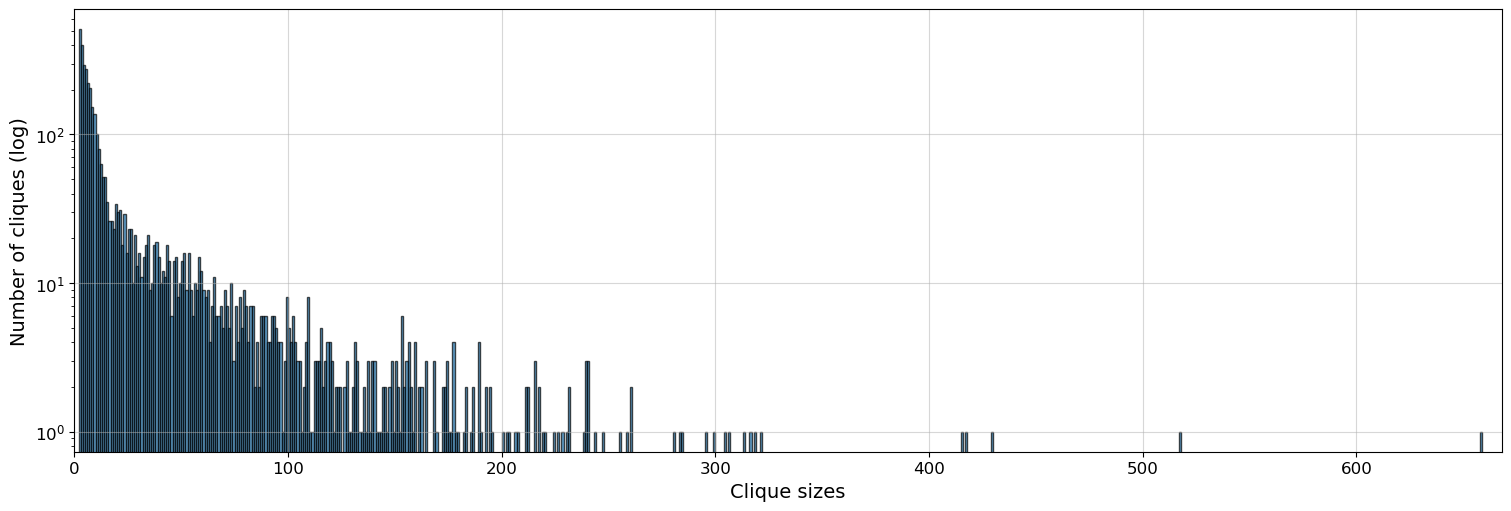

In [9]:
fig,ax = plt.subplots(figsize=(15,5), constrained_layout=True) # , dpi=1200
test_clique_sizes = list(test_clique_counter.keys())
test_clique_counts = list(test_clique_counter.values())
ax.bar(test_clique_sizes, height=test_clique_counts,
       width=1, align="edge", edgecolor="k", alpha=0.7)

ax.set_xlim(0, test_clique_sizes[-1]+10)
ax.set_yscale("log")
# ax.set_title("Clique Size Distribution", fontsize=20) #  - Each Version is Downloaded
ax.set_xlabel("Clique sizes", fontsize=14) # (number of versions in a clique)
ax.set_ylabel("Number of cliques (log)", fontsize=14)
# Make ticks bigger
ax.tick_params(axis='both', which='major', labelsize=12)
ax.grid(alpha=0.5)
# # ax.legend(loc=1, fontsize=8)
fig.savefig(os.path.join(figures_dir, "datacos_shs100k_version_distribution.png"), dpi=300)
plt.show()

In [10]:
# Print the number of versions in each clique
clique_counter = Counter([len(clique) for clique in dataset.values()])

# Sort the test_clique_sizes by keys
clique_counter = {k: clique_counter[k] for k in sorted(clique_counter.keys())}

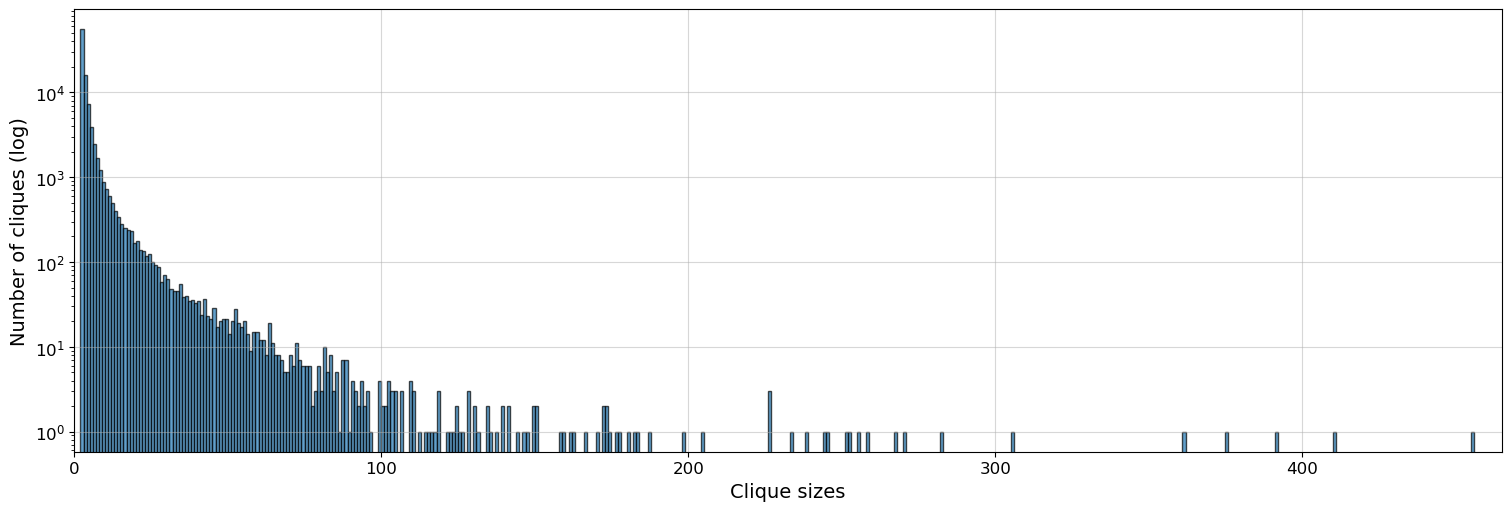

In [12]:
fig,ax = plt.subplots(figsize=(15,5), constrained_layout=True) # , dpi=1200
train_clique_sizes = list(clique_counter.keys())
train_clique_counts = list(clique_counter.values())
ax.bar(train_clique_sizes, height=train_clique_counts,
       width=1, align="edge", edgecolor="k", alpha=0.7)

ax.set_xlim(0, train_clique_sizes[-1]+10)
ax.set_yscale("log")
# ax.set_title("Clique Size Distribution", fontsize=20) #  - Each Version is Downloaded
ax.set_xlabel("Clique sizes", fontsize=14) # (number of versions in a clique)
ax.set_ylabel("Number of cliques (log)", fontsize=14)
# Make ticks bigger
ax.tick_params(axis='both', which='major', labelsize=12)
ax.grid(alpha=0.5)
# ax.legend(loc=1, fontsize=8)
fig.savefig(os.path.join(figures_dir, "remaining_distribution.png"), dpi=300)
plt.show()

## Partition

In [13]:
import random

In [14]:
print(f'10% of the total cliques: {int(n_total_cliques * 10 /100):>6,}')
print(f'There are {len(test_cliques):>6,} cliques reserved for the test set.')
test_required_cliques = int(n_total_cliques * 10 /100) - len(test_cliques)
print(f'  We need {test_required_cliques:>6,} more cliques for the test set for 10%.')

10% of the total cliques:  9,878
There are  3,763 cliques reserved for the test set.
  We need  6,115 more cliques for the test set for 10%.


In [15]:
test_n_versions = sum([x*y for x,y in zip(test_clique_sizes, test_clique_counts)])
print(f'Currently there are {test_n_versions:>6,} versions reserved for the test set.')

test_required_versions = int(n_total_versions * 10 /100) - test_n_versions
print(f'We need to get {test_required_versions:>6,} more versions for the test set for 10%.')

Currently there are 96,925 versions reserved for the test set.
We need to get -47,621 more versions for the test set for 10%.


In [16]:
n_total_versions - sum([x*y for x,y in zip(test_clique_sizes, test_clique_counts)])

396124

In [17]:
# Get the clique ids of the cliques with size up to 6
clique_2 = [clique_id for clique_id, clique in dataset.items() if len(clique) == 2]
clique_3 = [clique_id for clique_id, clique in dataset.items() if len(clique) == 3]
clique_4 = [clique_id for clique_id, clique in dataset.items() if len(clique) == 4]
clique_5 = [clique_id for clique_id, clique in dataset.items() if len(clique) == 5]
clique_6 = [clique_id for clique_id, clique in dataset.items() if len(clique) == 6]

In [20]:
k2 = 2600
k3 = 1540
k4 = 864
k5 = 670
k6 = 441
print(k2 + k3 + k4 + k5 + k6)

6115


In [21]:
random.seed(27) # License plate code of Gaziantep, gastronomical capital of Türkiye

add_to_test_2 = random.sample(clique_2, k=k2)
add_to_test_3 = random.sample(clique_3, k=k3)
add_to_test_4 = random.sample(clique_4, k=k4)
add_to_test_5 = random.sample(clique_5, k=k5)
add_to_test_6 = random.sample(clique_6, k=k6)

# Add the cliques to the test set and remove them from the dataset
for clique_id in add_to_test_2 + add_to_test_3 + add_to_test_4 + add_to_test_5 + add_to_test_6:
    test_cliques[clique_id] = dataset[clique_id]
    del dataset[clique_id]

In [22]:
# Count the number of versions per clique
print('Development Set')
n_cliques_dev = len(dataset)
print(f" Number of cliques: {n_cliques_dev:>7,}")
n_versions_dev = sum([len(clique) for clique in dataset.values()])
print(f"Number of versions: {n_versions_dev:>7,}")

# Count the number of versions per clique
print('Test Set')
n_cliques_test = len(test_cliques)
print(f" Number of cliques: {n_cliques_test:>7,}")
n_versions_test = sum([len(clique) for clique in test_cliques.values()])
print(f"Number of versions: {n_versions_test:>7,}")

Development Set
 Number of cliques:  88,907
Number of versions: 376,852
Test Set
 Number of cliques:   9,878
Number of versions: 116,197


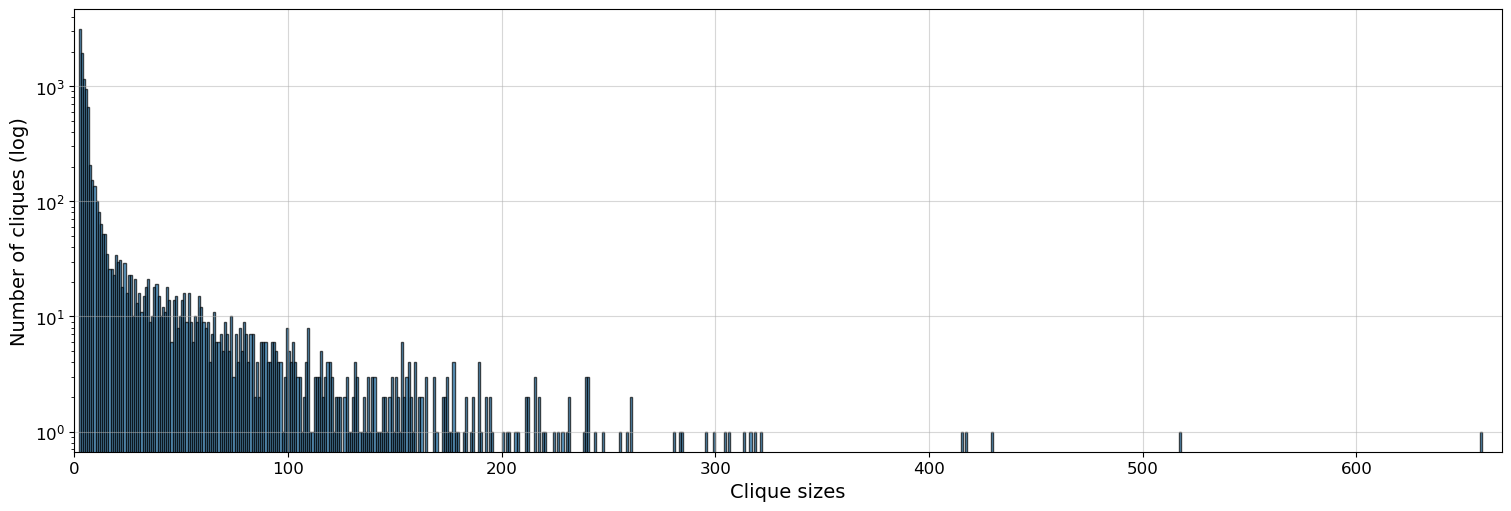

In [23]:
# Print the number of versions in each clique
test_clique_counter = Counter([len(clique) for clique in test_cliques.values()])

# Sort the test_clique_sizes by keys
test_clique_counter = {k: test_clique_counter[k] for k in sorted(test_clique_counter.keys())}

fig,ax = plt.subplots(figsize=(15,5), constrained_layout=True) # , dpi=1200
test_clique_sizes = list(test_clique_counter.keys())
test_clique_counts = list(test_clique_counter.values())
ax.bar(test_clique_sizes, height=test_clique_counts,
       width=1, align="edge", edgecolor="k", alpha=0.7)

ax.set_xlim(0, test_clique_sizes[-1]+10)
ax.set_yscale("log")
# ax.set_title("Clique Size Distribution", fontsize=20) #  - Each Version is Downloaded
ax.set_xlabel("Clique sizes", fontsize=14) # (number of versions in a clique)
ax.set_ylabel("Number of cliques (log)", fontsize=14)
# Make ticks bigger
ax.tick_params(axis='both', which='major', labelsize=12)
ax.grid(alpha=0.5)
# ax.legend(loc=1, fontsize=8)
fig.savefig(os.path.join(figures_dir, "test.png"), dpi=300)
plt.show()

In [24]:
# Write the test cliques to disk
if set(dataset.keys()).intersection(set(test_cliques.keys())) == set():
    with open(dataset_test_path, 'w') as out_f:
        json.dump(test_cliques , out_f, indent=4)
else:
    print('There is an intersection between the test and dev cliques')

In [25]:
# Sample validation cliques
random.seed(34) # License plate code of Istanbul
validation_clique_ids = random.sample(list(dataset.keys()), int(n_cliques_dev * 10 /100))

validation_cliques = dict()
for clique_id in validation_clique_ids:
    validation_cliques[clique_id] = dataset[clique_id]
    del dataset[clique_id]

# Count the number of versions per clique
n_cliques_valid = len(validation_cliques)
print('Validation Set')
print(f"Number of cliques: {n_cliques_valid:>7,}")
n_versions_valid = sum([len(clique) for clique in validation_cliques.values()])
print(f"Number of versions: {n_versions_valid:>7,}")

Validation Set
Number of cliques:   8,890
Number of versions:  37,081


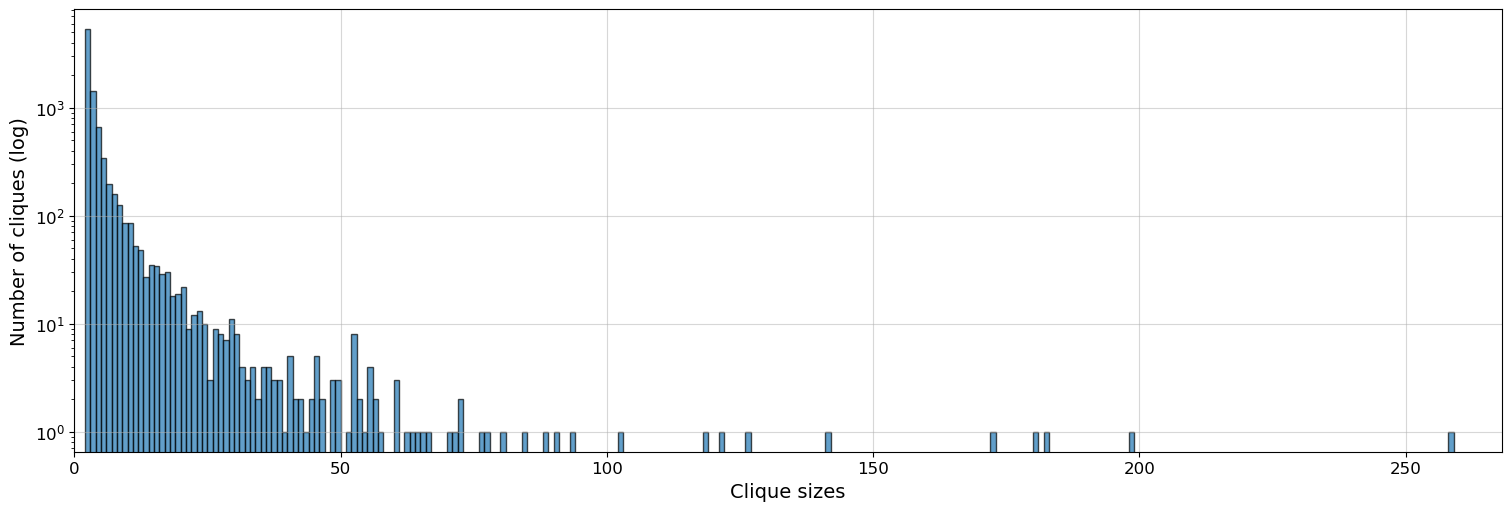

In [26]:
# Print the number of versions in each clique
validation_clique_counter = Counter([len(clique) for clique in validation_cliques.values()])

# Sort the validation_clique_sizes by keys
validation_clique_counter = {k: validation_clique_counter[k] for k in sorted(validation_clique_counter.keys())}

fig,ax = plt.subplots(figsize=(15,5), constrained_layout=True) # , dpi=1200
validation_clique_sizes = list(validation_clique_counter.keys())
validation_clique_counts = list(validation_clique_counter.values())
ax.bar(validation_clique_sizes, height=validation_clique_counts,
       width=1, align="edge", edgecolor="k", alpha=0.7)

ax.set_xlim(0, validation_clique_sizes[-1]+10)
ax.set_yscale("log")
# ax.set_title("Clique Size Distribution", fontsize=20) #  - Each Version is Downloaded
ax.set_xlabel("Clique sizes", fontsize=14) # (number of versions in a clique)
ax.set_ylabel("Number of cliques (log)", fontsize=14)
# Make ticks bigger
ax.tick_params(axis='both', which='major', labelsize=12)
ax.grid(alpha=0.5)
# ax.legend(loc=1, fontsize=8)
fig.savefig(os.path.join(figures_dir, "validation.png"), dpi=300)
plt.show()

In [27]:
# Count the number of versions per clique

# Count the number of versions per clique
print('Test Set')
n_cliques_test = len(test_cliques)
print(f" Number of cliques: {n_cliques_test:>7,}")
n_versions_test = sum([len(clique) for clique in test_cliques.values()])
print(f"Number of versions: {n_versions_test:>7,}")

n_cliques_valid = len(validation_cliques)
print('Validation Set')
print(f"Number of cliques: {n_cliques_valid:>7,}")
n_versions_valid = sum([len(clique) for clique in validation_cliques.values()])
print(f"Number of versions: {n_versions_valid:>7,}")

n_cliques_train = len(dataset)
print('Training Set')
print(f"Number of cliques: {n_cliques_train:>7,}")
n_versions_train = sum([len(clique) for clique in dataset.values()])
print(f"Number of versions: {n_versions_train:>7,}")

Test Set
 Number of cliques:   9,878
Number of versions: 116,197
Validation Set
Number of cliques:   8,890
Number of versions:  37,081
Training Set
Number of cliques:  80,017
Number of versions: 339,771


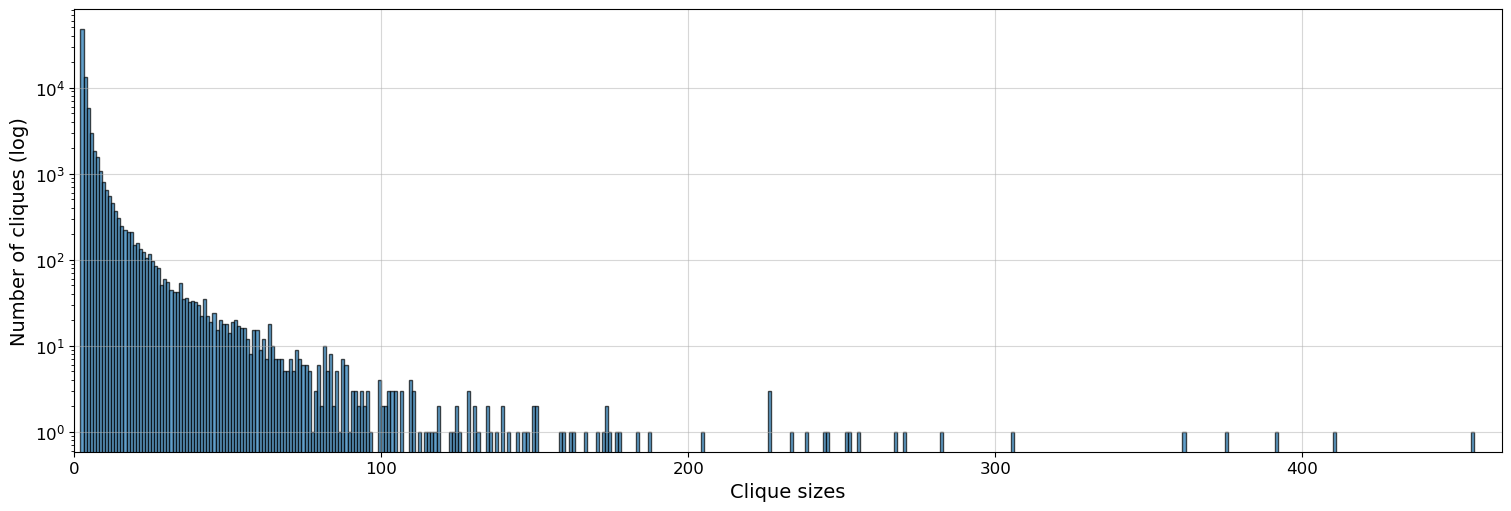

In [28]:
# Print the number of versions in each clique
train_clique_counter = Counter([len(clique) for clique in dataset.values()])

# Sort the train_clique_sizes by keys
train_clique_counter = {k: train_clique_counter[k] for k in sorted(train_clique_counter.keys())}

fig,ax = plt.subplots(figsize=(15,5), constrained_layout=True) # , dpi=1200
train_clique_sizes = list(train_clique_counter.keys())
train_clique_counts = list(train_clique_counter.values())
ax.bar(train_clique_sizes, height=train_clique_counts,
       width=1, align="edge", edgecolor="k", alpha=0.7)

ax.set_xlim(0, train_clique_sizes[-1]+10)
ax.set_yscale("log")
# ax.set_title("Clique Size Distribution", fontsize=20) #  - Each Version is Downloaded
ax.set_xlabel("Clique sizes", fontsize=14) # (number of versions in a clique)
ax.set_ylabel("Number of cliques (log)", fontsize=14)
# Make ticks bigger
ax.tick_params(axis='both', which='major', labelsize=12)
ax.grid(alpha=0.5)
# ax.legend(loc=1, fontsize=8)
fig.savefig(os.path.join(figures_dir, "train.png"), dpi=300)
plt.show()

In [29]:
if set(dataset.keys()).intersection(set(validation_cliques.keys())) == set():
    with open(dataset_val_path, 'w') as out_f:
        json.dump(validation_cliques , out_f, indent=4)
    with open(dataset_train_path, 'w') as out_f:
        json.dump(dataset , out_f, indent=4)

## Plot jointly

In [6]:
with open(dataset_val_path) as in_f:
    validation_cliques = json.load(in_f)
with open(dataset_train_path) as in_f:
    train_cliques = json.load(in_f)
with open(dataset_test_path) as in_f:
    test_cliques = json.load(in_f)

In [7]:
train_clique_sizes = np.array([len(clique) for clique in train_cliques.values()])
validation_clique_sizes = np.array([len(clique) for clique in validation_cliques.values()])
test_clique_sizes = np.array([len(clique) for clique in test_cliques.values()])

print(f'Maximum train clique size: {train_clique_sizes.max()}')
print(f'Maximum validation clique size: {validation_clique_sizes.max()}')
print(f'Maximum test clique size: {test_clique_sizes.max()}')

print(f'Median train clique size: {np.median(train_clique_sizes)}')
print(f'Median validation clique size: {np.median(validation_clique_sizes)}')
print(f'Median test clique size: {np.median(test_clique_sizes)}')

print(f'Mean train clique size: {train_clique_sizes.mean()}')
print(f'Mean validation clique size: {validation_clique_sizes.mean()}')
print(f'Mean test clique size: {test_clique_sizes.mean()}')

Maximum train clique size: 455
Maximum validation clique size: 258
Maximum test clique size: 658
Median train clique size: 2.0
Median validation clique size: 2.0
Median test clique size: 3.0
Mean train clique size: 4.246235175025308
Mean validation clique size: 4.171091113610799
Mean test clique size: 11.763211176351488


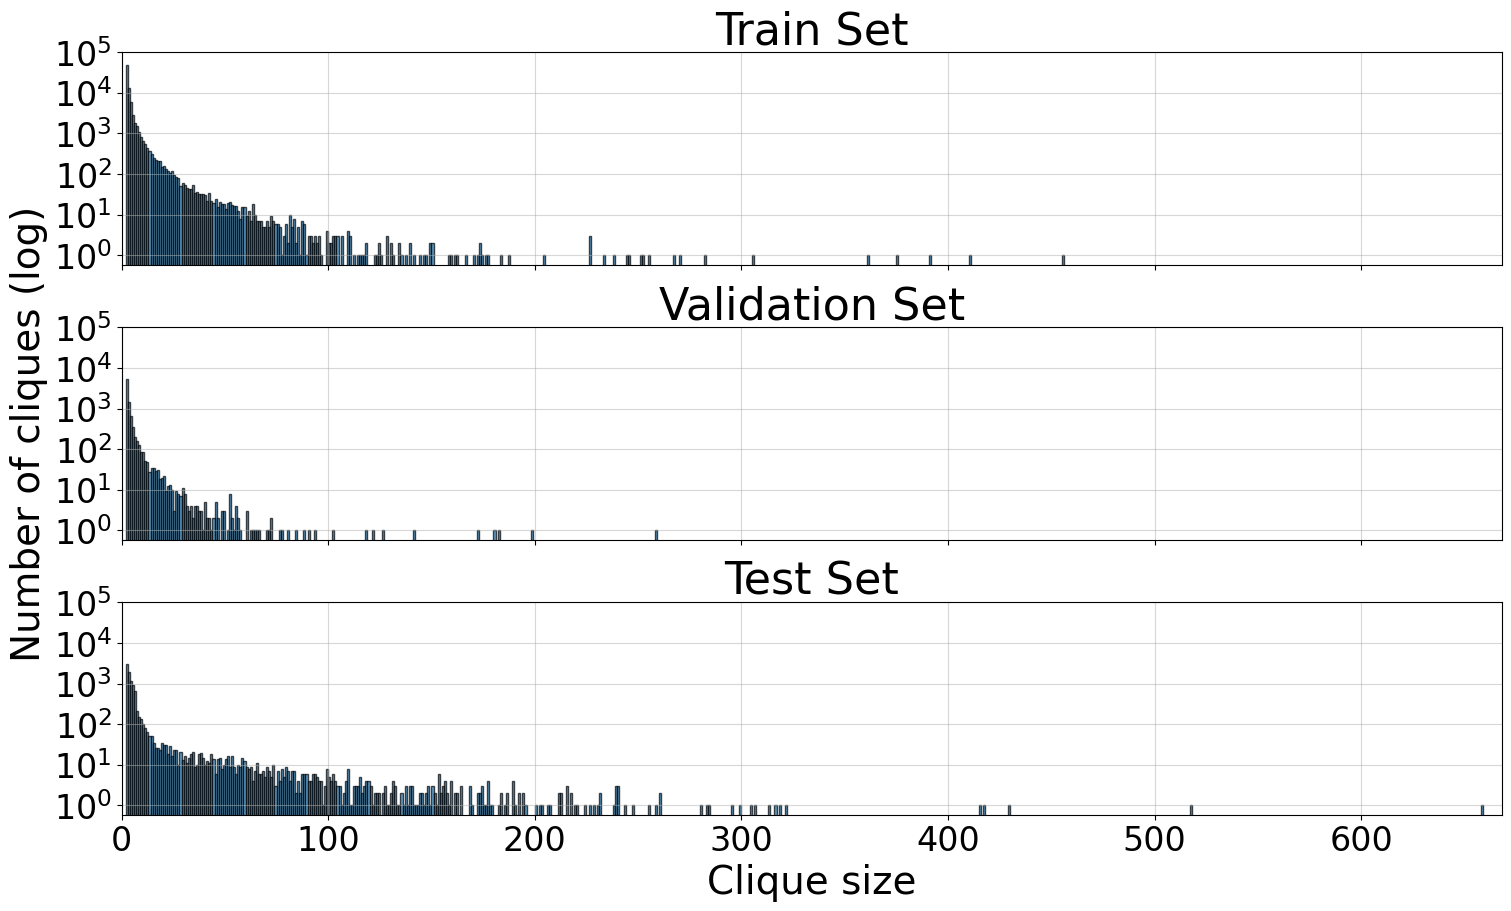

In [11]:
# Print the number of versions in each clique
test_clique_counter = Counter([len(clique) for clique in test_cliques.values()])
test_clique_counter = {k: test_clique_counter[k] for k in sorted(test_clique_counter.keys())}
test_clique_sizes = list(test_clique_counter.keys())
test_clique_counts = list(test_clique_counter.values())

train_clique_counter = Counter([len(clique) for clique in train_cliques.values()])
train_clique_counter = {k: train_clique_counter[k] for k in sorted(train_clique_counter.keys())}
train_clique_sizes = list(train_clique_counter.keys())
train_clique_counts = list(train_clique_counter.values())

validation_clique_counter = Counter([len(clique) for clique in validation_cliques.values()])
validation_clique_counter = {k: validation_clique_counter[k] for k in sorted(validation_clique_counter.keys())}
validation_clique_sizes = list(validation_clique_counter.keys())
validation_clique_counts = list(validation_clique_counter.values())

fig,ax = plt.subplots(nrows=3, sharex=True, sharey=True, figsize=(15,9), constrained_layout=True)

max_x = max(max(train_clique_sizes), max(validation_clique_sizes), max(test_clique_sizes))+10

ax[0].bar(train_clique_sizes, height=train_clique_counts, width=1, align="edge", edgecolor="k", alpha=0.7)
ax[0].set_title("Train Set", fontsize=32)
ax[0].set_yscale("log")

ax[1].bar(validation_clique_sizes, height=validation_clique_counts, width=1, align="edge", edgecolor="k", alpha=0.7)
ax[1].set_title("Validation Set", fontsize=32)
ax[1].set_ylabel("Number of cliques (log)", fontsize=28)
ax[1].set_yscale("log")

ax[2].bar(test_clique_sizes, height=test_clique_counts, width=1, align="edge", edgecolor="k", alpha=0.7)
ax[2].set_title("Test Set", fontsize=32)
ax[2].set_xlabel("Clique size", fontsize=28) # (number of versions in a clique)

for _x in ax:
    _x.grid(alpha=0.5)
    _x.tick_params(axis='x', which='major', labelsize=24)
    _x.tick_params(axis='y', which='major', labelsize=24)
    _x.set_yscale("log")
    _x.set_xlim([0, max_x])
    # Plot yticks every power of ten
    _x.set_yticks([10**i for i in range(0, 6)])

fig.savefig(os.path.join(figures_dir, "all_splits-no_suptitle.pdf"))
plt.show()